<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>
<h1 align="center"><font size="3">Author: Marcos José Rodrigues de Souza</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-03-03 13:14:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-03-03 13:14:59 (187 MB/s) - ‘loan_train.csv’ saved [23101/23101]



Get access to my Google drive to load the dataset

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### Load Data From CSV File


In [ ]:
df = pd.read_csv('loan_train.csv')
#df = pd.read_csv('/content/drive/MyDrive/Data Science Professional IBM/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
df.shape

(346, 10)

### Convert to date time object


In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


Alternative line code to install seaborn in Google Collab

In [ ]:
!pip install seaborn

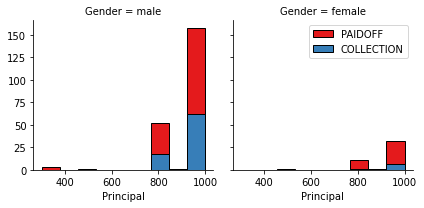

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

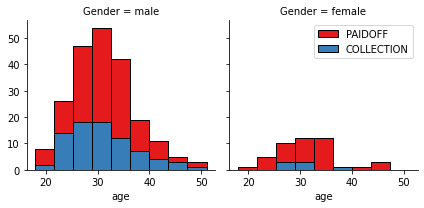

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


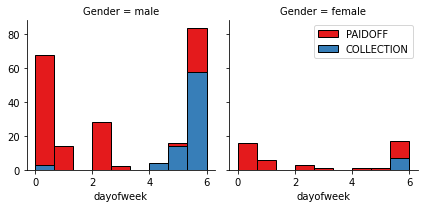

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [ ]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


Import library

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import train_test_split
from sklearn import metrics

Classifier implementing the k-nearest neighbors vote.

In [ ]:
Ks = 10

mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range (1,Ks):
    Kneigh = KNeighborsClassifier(n_neighbors = n).fit(X, y)
    y_hatKNN = Kneigh.predict(X)
    mean_acc[n-1]=metrics.accuracy_score(y, y_hatKNN)

    std_acc[n-1]=np.std(y_hatKNN==y)/np.sqrt(y_hatKNN.shape[0])

mean_acc    

array([0.86705202, 0.84104046, 0.82080925, 0.81213873, 0.81213873,
       0.80346821, 0.80057803, 0.80346821, 0.80346821])

####Plot the model accuracy for different numbers of neighbors

<function matplotlib.pyplot.show>

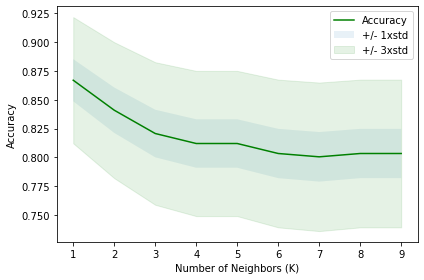

In [ ]:
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc -1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks), mean_acc -3 * std_acc, mean_acc + 3 * std_acc, alpha=0.10, color='green')
plt.legend(('Accuracy', '+/- 1xstd', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show

In [ ]:
print('The best accuracy was with', mean_acc.max(), 'with k =', mean_acc.argmax()+1)

The best accuracy was with 0.8670520231213873 with k = 1


# Decision Tree


###Modeling

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
#loanTree = DecisionTreeClassifier(criterion=sc, random_state=100, max_depth=3, min_samples_leaf=5)
#loanTree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1) 
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
loanTree


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [ ]:
loanTree = loanTree.fit(X, y)

###Prediction

In [ ]:
y_Tree = loanTree.predict(X)

print (y_Tree [0:5])
print (y [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


###Evaluation

In [ ]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y, y_Tree))

DecisionTrees's Accuracy:  0.7832369942196532


###Visualization 

In [ ]:
from sklearn import tree
from io import StringIO
import pydotplus
import matplotlib.image as mpimg

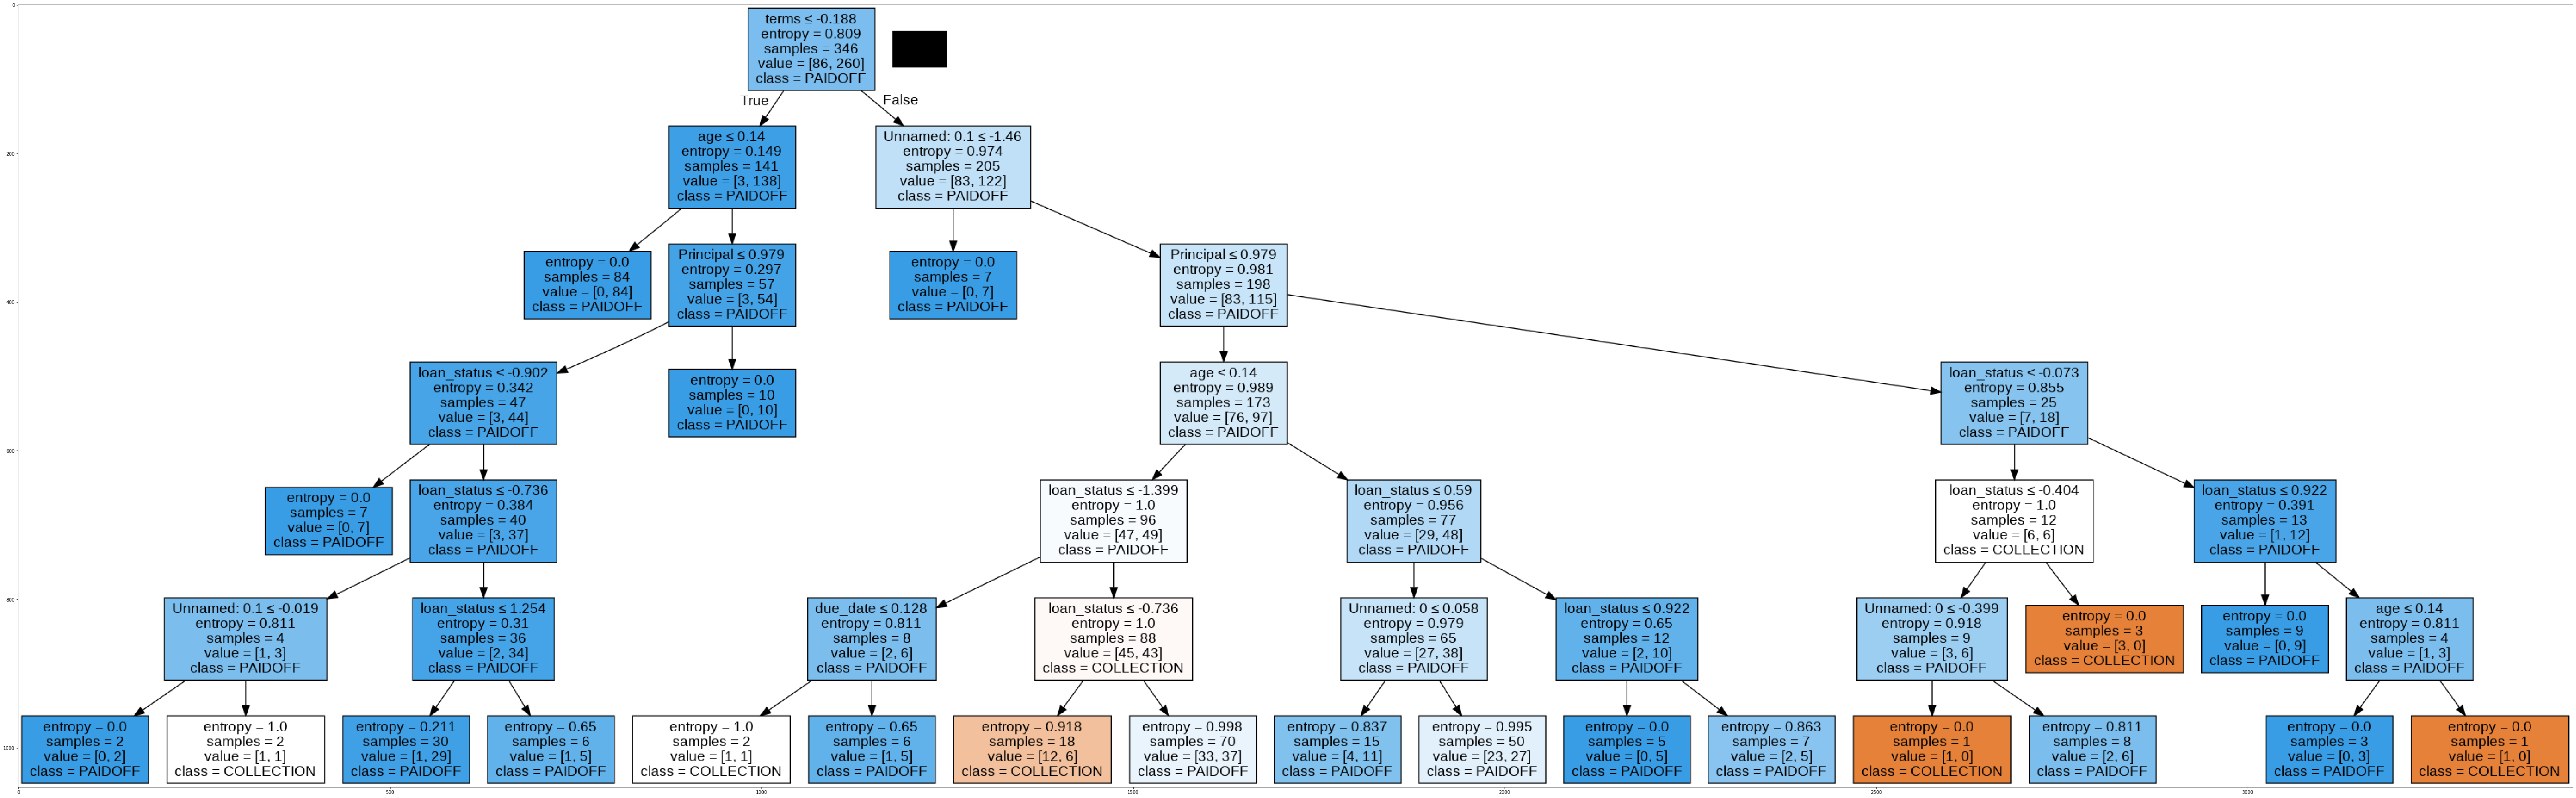

In [ ]:
dot_data = StringIO()
filename = 'loan_tree.png'
featureName = df.columns[0:8]
out=tree.export_graphviz(loanTree,feature_names=featureName, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [ ]:
from sklearn.svm import SVC

In [ ]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

In [ ]:
df = df[pd.to_numeric(df['education'], errors='coerce').notnull()]
df['education'] = df['education'].astype('int')
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                  int64
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

###Fit the model with Kernel RBF (Radial Basis Function)

In [ ]:
from sklearn import svm
SVM = svm.SVC(kernel='rbf').fit(X, y)

###Prediction

In [ ]:
yhat_SVM = SVM.predict(X)
yhat_SVM [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

###Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
accuracy_SVM = metrics.accuracy_score(y, yhat_SVM)
accuracy_SVM

0.7601156069364162

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       1.00      0.03      0.07        86
     PAIDOFF       0.76      1.00      0.86       260

    accuracy                           0.76       346
   macro avg       0.88      0.52      0.46       346
weighted avg       0.82      0.76      0.66       346

Confusion matrix, without normalization
[[260   0]
 [ 83   3]]


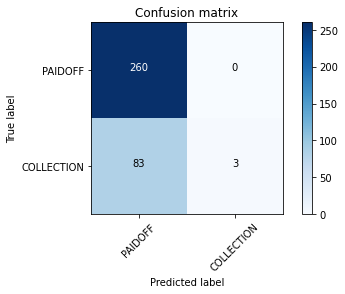

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat_SVM, labels=['PAIDOFF', 'COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y, yhat_SVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF', 'COLLECTION'],normalize= False,  title='Confusion matrix')

# Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

Define X and y 

In [ ]:
Feature_LR = X
#X = np.asarray(Feature)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [ ]:
y_LR = y
#y_LR = np.asarray(df['loan_status'])
y [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [ ]:
yhat_LR = LR.predict(X)
yhat_LR

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

In [ ]:
yhat_prob = LR.predict_proba(X)
yhat_prob

array([[0.31, 0.69],
       [0.26, 0.74],
       [0.28, 0.72],
       [0.42, 0.58],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.43, 0.57],
       [0.38, 0.62],
       [0.45, 0.55],
       [0.48, 0.52],
       [0.37, 0.63],
       [0.45, 0.55],
       [0.43, 0.57],
       [0.48, 0.52],
       [0.46, 0.54],
       [0.49, 0.51],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.49, 0.51],
       [0.43, 0.57],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.44, 0.56],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.43, 0.57],
       [0.49, 0.51],
       [0.49, 0.51],
       [0.39, 0.61],
       [0.43, 0.57],
       [0.44, 0.56],
       [0.44, 0.56],
       [0.41, 0.59],
       [0.43, 0.57],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.43, 0.57],
       [0.43, 0.57],
       [0.38, 0.62],
       [0.49, 0.51],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.49,

In [ ]:
accuracy_LR = metrics.accuracy_score(y, yhat_LR)
accuracy_LR

0.7485549132947977

# Model Evaluation using Test set


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-03-03 13:46:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-03-03 13:46:19 (661 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [ ]:
test_df.shape

(54, 10)

Convert to date time object

In [ ]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


## Test Dataset Pre-processing

In [ ]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

As we see in Train Dataset that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4

In [ ]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


Let's convert male to 0 and female to 1:

In [ ]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


###One Hot Encoding

In [ ]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


###Feature Selection and Normalize Test Dataset 

In [ ]:
test_X = Feature_test
test_y = test_df['loan_status'].values
print(test_X.shape, test_y.shape)

(54, 8) (54,)


In [ ]:
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

##Test Dataset Classification

###K Nearest Neighbor(KNN)

In [ ]:
yhatKNN=Kneigh.predict(test_X)
KNNJaccard = jaccard_score(test_y, yhatKNN, pos_label='PAIDOFF')
KNNF1 = f1_score(test_y, yhatKNN, average='weighted')
KNNLogloss = "NA"
print("KNN Jaccard Score: %.2f" % KNNJaccard)
print("Avg F1-score: %.2f" % KNNF1 )
print("KNN Logloss: %s" % KNNLogloss)

KNN Jaccard Score: 0.67
Avg F1-score: 0.65
KNN Logloss: NA


###Decision Tree

In [ ]:
yhatDT = loanTree.predict(test_X)
DTJaccard = jaccard_score(test_y, yhatDT, pos_label='PAIDOFF')
LogDT = f1_score(test_y, yhatDT, average='weighted')
DTLogloss = "NA"
print("Avg F1-score: %.4f" % LogDT)
print("LOG Jaccard score: %.4f" % DTJaccard)
print("Decision Tree Logloss: %s" % DTLogloss)

Avg F1-score: 0.7007
LOG Jaccard score: 0.7255
Decision Tree Logloss: NA


###Support Vector Machine

In [ ]:
yhatSVM = SVM.predict(test_X)
SVMJaccard = jaccard_score(test_y, yhatSVM, pos_label='PAIDOFF')
LogSVM = f1_score(test_y, yhatDT, average='weighted')
LoglossSVM = "NA"
print("Avg F1-score: %.4f" % LogSVM)
print("LOG Jaccard score: %.4f" %SVMJaccard)
print("SVM Logloss: %s" % LoglossSVM)

Avg F1-score: 0.7007
LOG Jaccard score: 0.7222
SVM Logloss: NA


####Logistic Regression

In [ ]:
yhatLOG = LR.predict(test_X)
yhatLOGproba = LR.predict_proba(test_X)
LogRegJaccard = jaccard_score(test_y, yhatLOG, pos_label='PAIDOFF')
LogRF1 = f1_score(test_y, yhatLOG, average='weighted')
LoglossLR = log_loss(test_y, yhatLOGproba)
print("LogLoss: : %.2f" % LoglossLR)
print("Avg F1-score: %.4f" % LogRF1)
print("LOG Jaccard score: %.4f" % LogRegJaccard)

LogLoss: : 0.56
Avg F1-score: 0.6304
LOG Jaccard score: 0.7407


In [ ]:
results = {}
results = {"Algorithm":["Jaccard", "F1-score", "LogLoss"]}
results["KNN"] = [KNNJaccard, KNNF1, ""]
results["Decision Tree"] = [DTJaccard, LogDT, "NA"]
results["SVM"] = [SVMJaccard, LogSVM, "NA"]
results["LogisticRegression"] = [LogRegJaccard, LogRF1, LoglossLR]
print(results)

{'Algorithm': ['Jaccard', 'F1-score', 'LogLoss'], 'KNN': [0.6730769230769231, 0.6453810131971051, ''], 'Decision Tree': [0.7254901960784313, 0.7006734006734008, 'NA'], 'SVM': [0.7222222222222222, 0.7006734006734008, 'NA'], 'LogisticRegression': [0.7407407407407407, 0.6304176516942475, 0.5566084946309205]}


In [ ]:
results = {}
results = {"Algorithm":["KNN","Decision Tree","SVM","LogisticRegression"]}
results["KNN"] = [KNNJaccard, KNNF1, ""]
results["Decision Tree"] = [DTJaccard, LogDT, "NA"]
results["SVM"] = [SVMJaccard, LogSVM, "NA"]
results["LogisticRegression"] = [LogRegJaccard, LogRF1, LoglossLR]
print(results)

{'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 'KNN': [0.6730769230769231, 0.6453810131971051, ''], 'Decision Tree': [0.7254901960784313, 0.7006734006734008, 'NA'], 'SVM': [0.7222222222222222, 0.7006734006734008, 'NA'], 'LogisticRegression': [0.7407407407407407, 0.6304176516942475, 0.5566084946309205]}


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [ ]:
tab_results = pd.DataFrame.from_dict(results, orient='index')
tab_results

,0,1,2
Algorithm,Jaccard,F1-score,LogLoss
KNN,0.673077,0.645381,
Decision Tree,0.72549,0.700673,NA
SVM,0.722222,0.700673,NA
LogisticRegression,0.740741,0.630418,0.556608



<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
